In [3]:
!pip install tensorflow
!pip install keras

     |████████████████████████████████| 462 kB 14.1 MB/s 


In [4]:
!pip install "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 20.0 MB/s 


In [5]:
import collections
import helper
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
import re
import typing
from typing import Any, Tuple

from numpy import array
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from numpy import argmax
from keras.models import load_model
from keras.layers import Dropout
 
from keras.optimizers import gradient_descent_v2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.losses import sparse_categorical_crossentropy

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
#@title Shape checker
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [18]:
# def load_data(path):
#   source_file = "/content/sentencesTrain.txt"
#   target_file = "/content/tokensTrain.txt"

#   text_pairs_source = []
#   text_pairs_target = []

#   with open(source_file,encoding="unicode_escape") as file1, open(target_file,encoding="unicode_escape") as file2:
#       for line1, line2 in zip(file1, file2):
#           line1 = line1.replace("\n", " ")
#           line1 = line1.strip()
          
#           line2 = line2.replace(",", " ")
#           line2 = line2.replace("\n", " ")
#           line2 = line2.strip()
#           text_pairs_source.append(line1)
#           text_pairs_target.append(line2)
#           print(line2)
#   return text_pairs_target,text_pairs_source

In [22]:
def load_data(path):
  source_file = "/content/sentencesTrain.txt"
  target_file = "/content/tokensTrain.txt"

  text_pairs_source = []
  text_pairs_target = []

  file1 = open('/content/sentencesTrain.txt', 'r',encoding='cp1252')
  Lines = file1.readlines()
  for line in Lines:
    #count += 1
    line1 = line.strip() 
    text_pairs_source.append(line1) 
  #file1.close()

  file2 = open('/content/tokensTrain.txt', 'r',encoding='cp1252')
  Lines = file2.readlines()
  for line in Lines:
    #count += 1
    line1 = line.strip() 
    text_pairs_target.append(line1) 
  #file2.close()
  return  text_pairs_target,text_pairs_source

In [23]:
target, inp = load_data("")

In [24]:
print(target)

['(P)PARTY,START,WHICH,TIME,EIGHT,TIME,NINE,(P)PARTY,START,WHICH,TIME', '(G/Q)POSS-1p,SISTER,(2h)IX-3p:i,tube skipping on water,IX-1p,GO-BY-BOAT,IX-1p,LOOK,MAKE,REALLY,person flips off,IX-1p,STOP,SISTER,(2h)IX-3p:i,tube skipping on water,GO-BY-BOAT,MAKE,STOP', 'MOTHER,IX-loc:i,#IF+,(1h)HAVE,TIME+,IX-3p:i,FUTURE,BRING,COOKIE,TIME+,BRING,COOKIE', '#NO+,IX-1p,NOT,OLD,ENOUGH,TO/UNTIL,VOTE,THAT,TIME,part:indef,ENOUGH,TO/UNTIL,VOTE,TIME,part:indef', 'FRIEND,WANT_2,BUY,PLAID,(2h)SHIRT,FRIEND,WANT_2,BUY,(2h)SHIRT', '#IF,TOMORROW,SNOW,GUARANTEE,SCHOOL,FUTURE,CLOSE-DOOR,SNOW,GUARANTEE,SCHOOL,CLOSE-DOOR', 'IX-1p,RECENT-PAST,DRINK,TASTE,FINE++,(1h)part:indef', '#IF,MOTHERwg,IX-3p:i,NOT,person walking,SELL,IX-1p-pl-arc,REFUSE,(1h)HAVE,MILK,part:indef,SELL,(1h)part:indef,part:indef', 'FINEwg,MOTHERwg,FUTURE,GIVE-1p,TWENTY,DOLLAR,#IF,IX-1p,NICE/CLEAN,(K)KITCHEN,DOLLAR,NICE/CLEAN,(K)KITCHEN', 'TEACH+AGENT,IX-loc:i,IX-3p-pl-arc,HEAR/LISTEN,IX-3p:i,WHO,TEACH,AGENT,BUOY,IX-3p:j', 'IX-1p,RECENT-PAST,READ+

In [25]:
print(inp)

['When does the party start, at 8 or 9?', 'When my sister goes water tubing, I will have to watch her and make sure to stop the boat when she falls off.', 'If mom has time she will bring cookies.', "No, I wasn't old enough to vote at that time.", 'My friend wants to buy a plaid shirt.', "If it snows tomorrow, then it's a guarantee that school will be closed.", 'I just drank it and it tastes fine.', "If mom doesn't walk to the store, we won't have milk.", 'Mother will give me twenty dollars if I clean the kitchen.', 'Who listened to the teacher?', 'I just read a book.', 'It can be expressed through speech or through sign language.', "It doesn't matter to me. I like anything.", "No, today's Thursday, which means tomorrow's Friday.", 'Where did the friends drive to?', 'My friend is playing video games.', 'What does my sister want for her birthday?', 'Has your friend experienced travelling?', "Bob hasn't sent the letter.", 'If my family decides to vacation every year, they will go to Puert

In [26]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, target)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [27]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'When a friend calls me via VP, the lights flash on and off.'
 b'If my friend goes out to a party, my roommate and I will join.'
 b'If my friends go camping, I will go with them.'
 b'They are basically based on the idea of how human language is expressed.'
 b'No, I just came back from dinner. They had no ice cream.'], shape=(5,), dtype=string)

tf.Tensor(
[b'WHEN,FRIEND,i:CALL-ON-RELAY/VRS-1p,#VP,LIGHT,LIGHT-FLASH,WHEN,FRIEND,i:CALL-ON-RELAY/VRS-1p,LIGHT-FLASH'
 b'#IF,POSS-1p,FRIEND,DEPART,(P)PARTY+,IX-1p,POSS-1p,ROOMMATE,IX-1p-pl-2:i,(1h)JOIN,FRIEND,(P)PARTY+,ROOMMATE'
 b'#IF,POSS-1p,FRIEND,GO-OUT,CAMP+,IX-1p,FUTURE,GO-OUT,WITH,IX-pl-arc,FRIEND,CAMP+,WITH'
 b'BELOW_2,ON,IDEA,HOW,fs-HUMAN,LANGUAGE,EXPRESS,BELOW_2,ON,HOW,LANGUAGE,EXPRESS'
 b'#NO+,IX-1p,RECENT-PAST,#BACK_2,FROM,DINNER,IX-3p:i,NONE/NOTHING,ICE-CREAM,IX-honorific:i,FROM,NONE/NOTHING'], shape=(5,), dtype=string)


In [28]:
def lower(text):
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [29]:
max_vocab_size = 700

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=lower,
    max_tokens=max_vocab_size)

In [30]:
input_text_processor.adapt(inp)

input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'the', 'I', 'to', 'If', 'a', 'is']

In [31]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=lower,
    max_tokens=max_vocab_size)

output_text_processor.adapt(target)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'go', 'wave', 'passed', 'of', 'out', "don't"]

In [32]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  2,  23,   8,  15, 427,  66,   1,   1,   4, 623],
       [  2,   7,  10,  15,  72,  38,   6,   8, 107,  10],
       [  2,   7,  10,  32,  34,   1,   5,  11,  34,  33]])>

In [33]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] When a friend calls me [UNK] [UNK] the lights flash on and off. [END]               '

In [34]:
embedding_dim = 1024
units = 1024

In [35]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [36]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 30)
Encoder output, shape (batch, s, units): (64, 30, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [37]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [38]:
attention_layer = BahdanauAttention(units)

In [39]:
(example_tokens != 0).shape

TensorShape([64, 30])

In [40]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 30)


In [41]:
attention_weights.shape

TensorShape([64, 2, 30])

In [42]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [44]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [45]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [46]:
Decoder.call = call

In [47]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [48]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [49]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 700)
state shape: (batch_size, dec_units) (64, 1024)


In [50]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [51]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]

In [52]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [53]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]

In [54]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [55]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [56]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [57]:
TrainTranslator._preprocess = _preprocess

In [58]:
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [59]:
TrainTranslator._train_step = _train_step

In [60]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [61]:
TrainTranslator._loop_step = _loop_step

In [62]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [63]:
np.log(output_text_processor.vocabulary_size())

6.551080335043405

In [64]:
%%time
for n in range(20):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.701548>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4044375>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.3807578>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.7844963>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.7824345>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.8644052>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9914012>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.8118088>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.4843166>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.1276562>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.2165172>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.1443477>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.9035554>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.8226991>}
{'batch_loss': <tf.Te

In [65]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [66]:
TrainTranslator._tf_train_step = _tf_train_step
translator.use_tf_function = True
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4963559>}

In [67]:
%%time
for n in range(20):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4473816>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.4000727>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3683953>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3437395>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.3141403>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2749864>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.2293483>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.1834801>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.1401008>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.0968708>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.0519238>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=1.0056882>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.9583792>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.90941054>}
{'batch_loss': <tf.

....................................................................................................


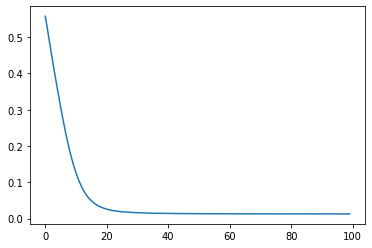

In [68]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [69]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [70]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [71]:
train_translator.fit(dataset, epochs=50,callbacks=[batch_loss])

Epoch 1/50
11/11 [==============================] - 7s 169ms/step - batch_loss: 3.8760
Epoch 2/50
11/11 [==============================] - 2s 181ms/step - batch_loss: 2.8075
Epoch 3/50
11/11 [==============================] - 2s 165ms/step - batch_loss: 2.6204
Epoch 4/50
11/11 [==============================] - 2s 172ms/step - batch_loss: 2.4080
Epoch 5/50
11/11 [==============================] - 2s 168ms/step - batch_loss: 2.2486
Epoch 6/50
11/11 [==============================] - 2s 168ms/step - batch_loss: 2.1377
Epoch 7/50
11/11 [==============================] - 2s 177ms/step - batch_loss: 1.9639
Epoch 8/50
11/11 [==============================] - 2s 158ms/step - batch_loss: 1.7181
Epoch 9/50
11/11 [==============================] - 2s 167ms/step - batch_loss: 1.5696
Epoch 10/50
11/11 [==============================] - 2s 164ms/step - batch_loss: 1.3389
Epoch 11/50
11/11 [==============================] - 2s 170ms/step - batch_loss: 1.1380
Epoch 12/50
11/11 [======================

Text(0, 0.5, 'CE/token')

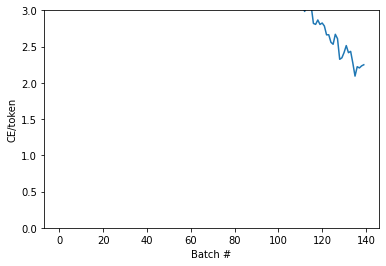

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [72]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [73]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [74]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [75]:
Translator.tokens_to_text = tokens_to_text

In [76]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'no,NOT,SMALL,wave PAST+,TAKE-BREAK,IX-1p,READY,#DO,HOMEWORK,FROM-NOW-ON,EMPTY-FROM-NOW-ON,READY,TAKE-BREAK,READY,HOMEWORK,FROM-NOW-ON,EMPTY-FROM-NOW-ON,READY',
       b'POSS-1p,FRIEND,IX-3p:i,LOVE,TRIP,UNDERSTAND,KISS-FIST,fs-ASIA,ns-ASIA,(25)WHY,IX-loc:i,fs-ASIA,MANY,(2h)THING,DO-DO,DIFFERENT++,VARY,COMPARE,TO/UNTIL,OTHER,COUNTRY+,FRIEND,LOVE,focus,MANY,(2h)THING,DO-DO,DIFFERENT++,VARY,COMPARE,TO/UNTIL,COUNTRY+ IX-1p,SAY,fs-JOHN,wave',
       b'MUST,#VP,WHY++,(1h)part:indef,CAN,TEXTING,part:indef,CAN,TEXTING,part:indef fs-BILL,PLAN,(1h)MOVE,ns-NEW-YORK,QMwg,PLAN,ns-NEW-YORK',
       b'NOT,HAVE,TIME,TOMORROW,not KISS-FIST,LOOK,FIREWORKS,WHO,FIREWORKS',
       b'IX-3p:i,DOG,CHASE,CAT,THAT,IX-3p:i,#DOG,IX-3p:i,NOT,POSS-1p+,IX-3p:i,CHASE,IX-3p:i MOST,FOCUS/NARROW,ns-AMERICA,CULTURE,GIFT,MEAN,INTERPRET,TO/UNTIL,DIFFERENT-arc,NOISE,VOICE+,MOST,FOCUS/NARROW,ns-AMERICA,CULTURE,GIFT,MEAN,INTERPRET,TO/UNTIL,DIFFERENT-arc,NOISE'],
      dtype=object)

In [77]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [78]:
Translator.sample = sample

In [79]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[643],
       [301],
       [366],
       [466],
       [637]])>

In [80]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [81]:
Translator.translate = translate_unrolled

In [82]:
%%time
input_text = tf.constant([
    "I starting making an invitation list for my BBQ party, I will have to make sure it's right.", 
    "If Father arrives home late, he can’t help us with our homework.", 
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

IX-1p,PROCEED,START,FILL-OUT,FRIEND,(2h)alt.INVITE/HIRE,FOR,#BBQ,GROUP/TOGETHER,IX-1p,MAKE,REALLY,LIST,#ALL,CORRECT,PROCEED,START,FILL-OUT,FRIEND,(2h)alt.INVITE/HIRE,GROUP/TOGETHER,MAKE,LIST,CORRECT
WHO,(1h)TEND,COMMUTE,BICYCLE,WHO,BICYCLE

CPU times: user 122 ms, sys: 2.71 ms, total: 124 ms
Wall time: 132 ms


In [88]:
test_file = "/content/sentencesTest.txt"

testfile = "tokensTest.txt"
tstfile = open(testfile, "w") 



In [89]:
test_lines=[]
file3= open('/content/sentencesTrain.txt', 'r',encoding='cp1252')
lines_test =file3.readlines()
print(lines_test)

for input_sentence in lines_test:
    
    
    #input_sentence = random.choice(line2)
    list_data = []
    list_data.append(input_sentence)
    input_text = tf.constant(list_data)
    result = translator.translate(input_text = input_text)

    #print(result['text'][0].numpy().decode())
    
    translated = result['text'][0].numpy().decode()
    translated = translated.replace(" ", ",")
    
    tstfile.write(translated+'\n')

tstfile.close()

['When does the party start, at 8 or 9?\n', 'When my sister goes water tubing, I will have to watch her and make sure to stop the boat when she falls off.\n', 'If mom has time she will bring cookies.\n', "No, I wasn't old enough to vote at that time.\n", 'My friend wants to buy a plaid shirt.\n', "If it snows tomorrow, then it's a guarantee that school will be closed.\n", 'I just drank it and it tastes fine.\n', "If mom doesn't walk to the store, we won't have milk.\n", 'Mother will give me twenty dollars if I clean the kitchen.\n', 'Who listened to the teacher?\n', 'I just read a book.\n', 'It can be expressed through speech or through sign language.\n', "It doesn't matter to me. I like anything.\n", "No, today's Thursday, which means tomorrow's Friday.\n", 'Where did the friends drive to?\n', 'My friend is playing video games.\n', 'What does my sister want for her birthday?\n', 'Has your friend experienced travelling?\n', "Bob hasn't sent the letter.\n", 'If my family decides to vaca